<a href="https://colab.research.google.com/github/Parikshit07111996/School-Of-AI/blob/master/Assignment_6_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model for 25 epochs for each:
###1) without L1/L2 with BN
###2)without L1/L2 with GBN
###3)with L1 with BN
###4)with L1 with GBN
###5)with L2 with BN
###6)with L2 with GBN
###7)with L1 and L2 with BN
###8)with L1 and L2 with GBN

#Loading Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# Batch Normalization & GhostBatch Normalization



In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

# Model


In [0]:
def getBatchNorm(type, num_features, num_splits=2):
  if type == 'GBN':
    return GhostBatchNorm(num_features, num_splits)
  else:
    return nn.BatchNorm2d(num_features)

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self, batch_type):
        super(Net, self).__init__()


        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            getBatchNorm(batch_type, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Parameters 
### Making it a function

In [0]:
def getModel(device, batch_type='BN'):
  model = Net(batch_type).to(device)
  return model

def getDevice():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  return device

def getModelSummary(model):
  summary(model, input_size=(1, 28, 28))

In [0]:
def getDataLoader(batchSize):
  BATCH_SIZE = batchSize
  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
  return dataloader_args

In [0]:
def L1_Loss(model, loss, l1_factor=0.0005):
    # l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
          # zero_vector = torch.rand_like(param) * 0
          reg_loss += torch.sum(param.abs())

    loss += l1_factor * reg_loss
    return loss

In [0]:
def getTrainDataLoader(dataloader_args):
  # Train Phase transformations
  train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) 
                                        ])
  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
  return train_loader

In [0]:
def getOptimizer(model, lr=0.01, weight_decay=0):
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
  # scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  return optimizer

def train(model, device, train_loader, optimizer, epoch, l1_factor=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_factor:
      loss = L1_Loss(model, loss)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [0]:
def getTestDataLoader(dataloader_args):
  # Test Phase transformations
  test_transforms = transforms.Compose([ transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
  return test_loader

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
def getMisclassifiedImages(batch_type, modelPath):
  model = Net(batch_type)
  model.load_state_dict(torch.load(modelPath))
  model.cuda()
  model.eval()
  misclassifiedImages = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          target_modified = target.view_as(pred)
          for i in range(len(pred)):
            if pred[i].item()!= target_modified[i].item():
                misclassifiedImages.append([data[i], pred[i], target_modified[i]])

  fig3 = plt.figure(figsize = (15,15))
  for i, im in enumerate(misclassifiedImages[:25]):
      sub = fig3.add_subplot(5, 5, i+1)
      plt.imshow(im[0].cpu().numpy().squeeze(), cmap='gray_r',interpolation='none')
      sub.set_title("Prediction : %s, Actual: %s" % (im[1].data.cpu().numpy()[0], im[2].data.cpu().numpy()[0]))
  plt.tight_layout()
  plt.show()

In [0]:
def saveModel(model, modelPath):
  torch.save(model.state_dict(), modelPath)

In [0]:
!mkdir saved_models

In [14]:
methods = ['BN','GBN','L1_BN','L1_GBN','L2_BN','L2_GBN','L1_L2_BN','L1_L2_GBN']

device = getDevice()
EPOCHS = 25
tot_test_losses = {}
tot_test_acc = {}
tot_train_losses = {}
tot_train_acc = {}
l1_factor = 0
l2_weight_decay = 0
for method in methods:
  print("======================================================================= ", method, " ===============================================================================")
  if method == 'BN' or method == 'L1_BN' or method == 'L2_BN' or method == 'L1_L2_BN':
    BATCH_SIZE = 64
    model =  getModel(device, 'BN')
  if method == 'GBN' or method == 'L1_GBN' or method == 'L2_GBN' or method == 'L1_L2_GBN':
    BATCH_SIZE = 128
    model =  getModel(device, 'GBN')
  if method == 'L1_BN' or method == 'L1_GBN' or method == 'L1_L2_BN' or method == 'L1_L2_GBN':
    l1_factor = 0.0005
  else:
    l1_factor = 0
  if method == 'L2_BN' or method == 'L2_GBN' or method == 'L1_L2_BN' or method == 'L1_L2_GBN':
    l2_weight_decay = 0.0005
  else:
    l2_weight_decay = 0

  getModelSummary(model)
  optimizer = getOptimizer(model, 0.01, l2_weight_decay)
  dataLoaderArgs = getDataLoader(BATCH_SIZE)
  train_loader = getTrainDataLoader(dataLoaderArgs)
  test_loader = getTestDataLoader(dataLoaderArgs)
  test_losses = []
  test_acc = []
  train_losses = []
  train_acc = []
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, l1_factor)
      test(model, device, test_loader)
  tot_test_losses[method] = test_losses
  tot_test_acc[method] = test_acc
  tot_train_losses[method] = train_losses
  tot_train_acc[method] = train_acc
  saveModel(model, 'saved_models/'+method+'.pt')

=======================================================================  BN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
          

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
  0%|          | 0/938 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
EPOCH: 0




Loss=0.1798131912946701 Batch_id=937 Accuracy=90.39: 100%|██████████| 938/938 [00:26<00:00, 35.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.04741412401199341 Batch_id=937 Accuracy=97.38: 100%|██████████| 938/938 [00:26<00:00, 35.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.07265117764472961 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:26<00:00, 36.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9913/10000 (99.13%)

EPOCH: 3


Loss=0.023803338408470154 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [00:25<00:00, 36.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.03259672224521637 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:25<00:00, 36.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9931/10000 (99.31%)

EPOCH: 5


Loss=0.02702072262763977 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:25<00:00, 36.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.04190409183502197 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:25<00:00, 36.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.09483224898576736 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:25<00:00, 36.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.11006073653697968 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:25<00:00, 37.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.016437172889709473 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:25<00:00, 37.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.04012337327003479 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:25<00:00, 36.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.03457126021385193 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:25<00:00, 36.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.02822454273700714 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:25<00:00, 36.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.1467781513929367 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:25<00:00, 36.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.01362551748752594 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:25<00:00, 36.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.007464319467544556 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:25<00:00, 36.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.05150005221366882 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:25<00:00, 36.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


Loss=0.03139814734458923 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:25<00:00, 36.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.044709473848342896 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:25<00:00, 36.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.013556212186813354 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:25<00:00, 36.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Loss=0.06866179406642914 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:25<00:00, 36.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


Loss=0.0026889294385910034 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:25<00:00, 36.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.0026698708534240723 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:25<00:00, 37.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)

EPOCH: 23


Loss=0.015675708651542664 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:25<00:00, 36.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.008717954158782959 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:25<00:00, 36.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

=======================================================================  GBN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        M

Loss=0.19627900421619415 Batch_id=468 Accuracy=87.86: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0880, Accuracy: 9758/10000 (97.58%)

EPOCH: 1


Loss=0.14700575172901154 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.09915968030691147 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.06803608685731888 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.031373899430036545 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.04207905754446983 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.060722466558218 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.021082794293761253 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.02467469871044159 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.07511500269174576 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.01197527814656496 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.03000561334192753 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.010750909335911274 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.06716161966323853 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.013090754859149456 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.01801857352256775 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.08628489822149277 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.026903018355369568 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.07285407930612564 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.03947634622454643 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.03224632143974304 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.05033927038311958 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 24.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.01575724221765995 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.04734514653682709 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.02397173084318638 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

=======================================================================  L1_BN  ===============================================================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
       

Loss=0.36725664138793945 Batch_id=937 Accuracy=91.56: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1002, Accuracy: 9696/10000 (96.96%)

EPOCH: 1


Loss=0.4220440983772278 Batch_id=937 Accuracy=96.99: 100%|██████████| 938/938 [00:29<00:00, 32.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1003, Accuracy: 9675/10000 (96.75%)

EPOCH: 2


Loss=0.2511955499649048 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:29<00:00, 31.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


Loss=0.2600614130496979 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:29<00:00, 31.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9809/10000 (98.09%)

EPOCH: 4


Loss=0.21409736573696136 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:29<00:00, 31.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9848/10000 (98.48%)

EPOCH: 5


Loss=0.2557148337364197 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:29<00:00, 31.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9839/10000 (98.39%)

EPOCH: 6


Loss=0.37365254759788513 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [00:29<00:00, 31.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9774/10000 (97.74%)

EPOCH: 7


Loss=0.3714783191680908 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:29<00:00, 31.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Loss=0.2840502858161926 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:29<00:00, 31.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0789, Accuracy: 9749/10000 (97.49%)

EPOCH: 9


Loss=0.28723788261413574 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:29<00:00, 31.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.19189463555812836 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:29<00:00, 32.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9803/10000 (98.03%)

EPOCH: 11


Loss=0.3158622980117798 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:29<00:00, 31.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9866/10000 (98.66%)

EPOCH: 12


Loss=0.21353259682655334 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:29<00:00, 31.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9837/10000 (98.37%)

EPOCH: 13


Loss=0.3772332966327667 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:29<00:00, 31.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9814/10000 (98.14%)

EPOCH: 14


Loss=0.251598596572876 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:29<00:00, 31.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9876/10000 (98.76%)

EPOCH: 15


Loss=0.20676282048225403 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:29<00:00, 31.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9823/10000 (98.23%)

EPOCH: 16


Loss=0.3486805260181427 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:29<00:00, 31.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9876/10000 (98.76%)

EPOCH: 17


Loss=0.254222571849823 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:41<00:00, 22.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9821/10000 (98.21%)

EPOCH: 18


Loss=0.2008551061153412 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:31<00:00, 30.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9851/10000 (98.51%)

EPOCH: 19


Loss=0.3691253066062927 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:30<00:00, 30.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9816/10000 (98.16%)

EPOCH: 20


Loss=0.2208714783191681 Batch_id=69 Accuracy=97.14:   7%|▋         | 66/938 [00:02<00:28, 30.07it/s]

Buffered data was truncated after reaching the output size limit.

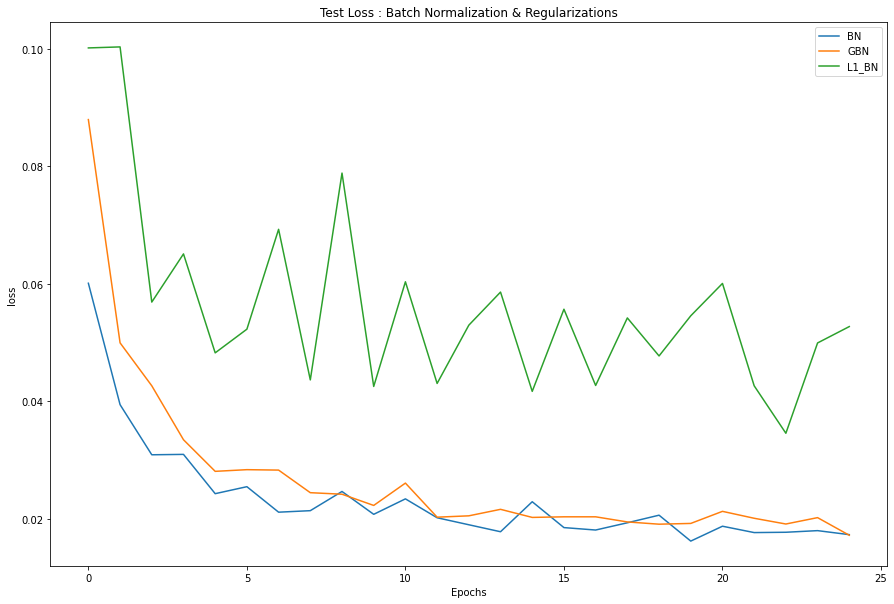

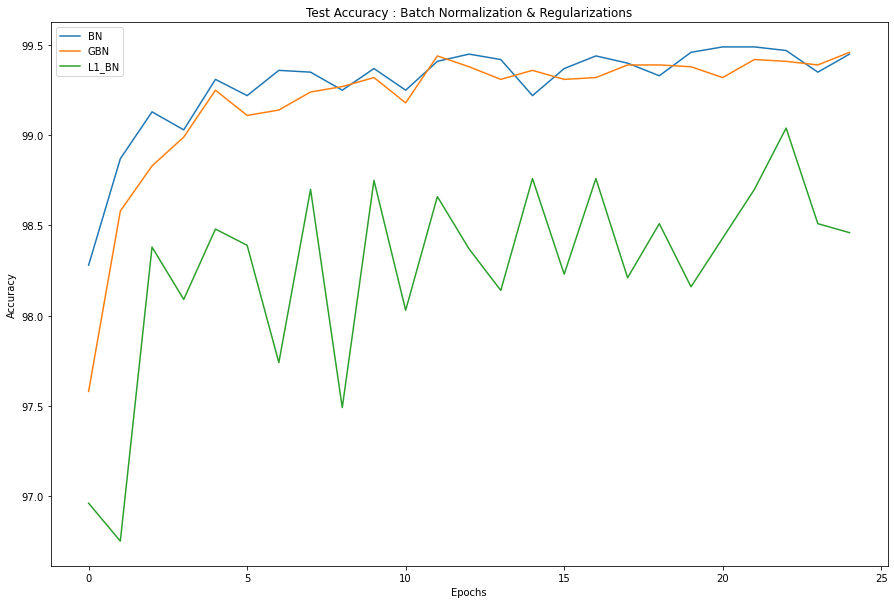

In [15]:
import pandas as pd
testing_all_loss = pd.DataFrame(tot_test_losses)
testing_all_accuracy = pd.DataFrame(tot_test_acc)

fig1 = testing_all_loss.plot(figsize=(15,10), kind = 'line', title = "Test Loss : Batch Normalization & Regularizations")
fig1.set_xlabel("Epochs")
fig1.set_ylabel("loss")

fig2 = testing_all_accuracy.plot(figsize=(15,10), kind = 'line', title = "Test Accuracy : Batch Normalization & Regularizations")
fig2.set_xlabel("Epochs")
fig2.set_ylabel("Accuracy")

fig1
fig2

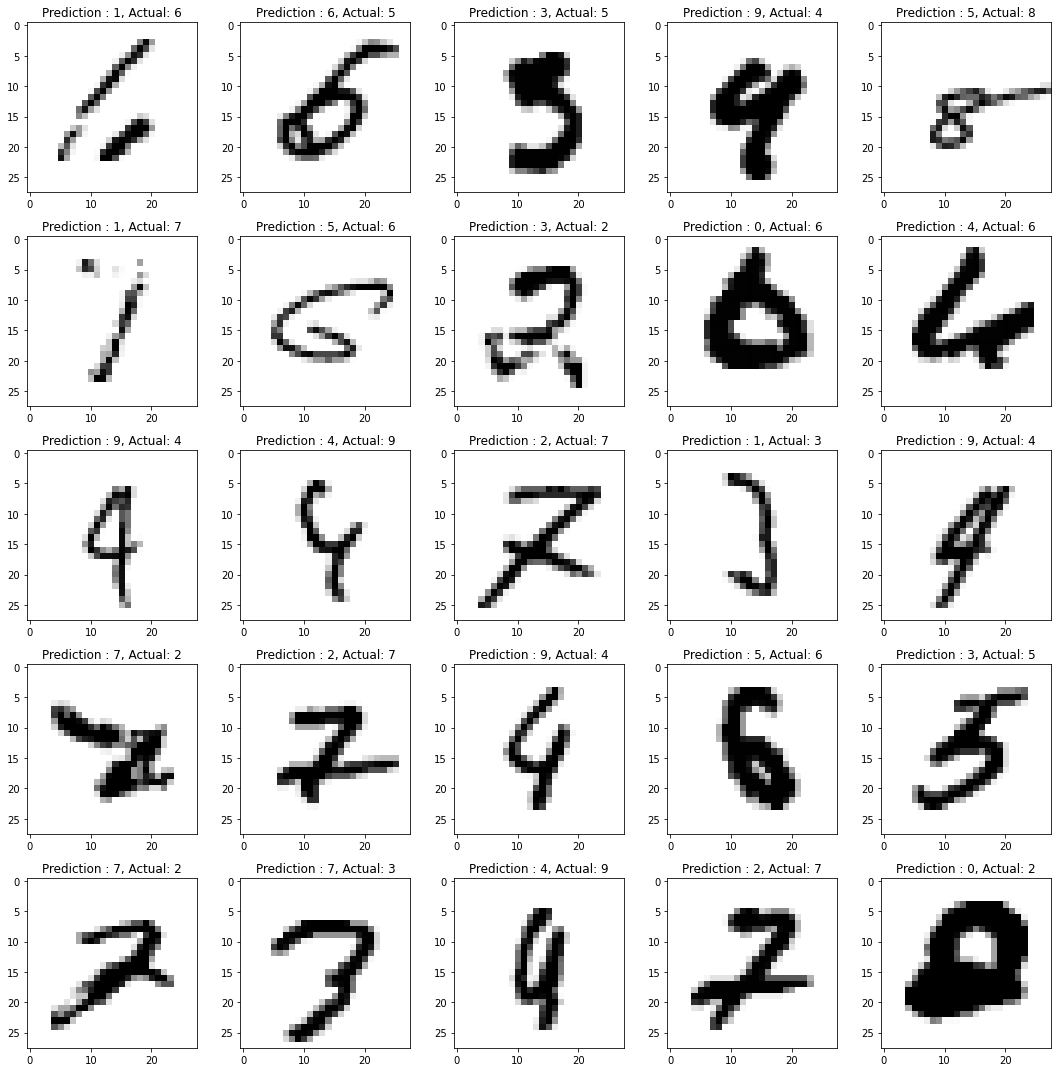

In [16]:
getMisclassifiedImages('BN', 'saved_models/BN.pt')

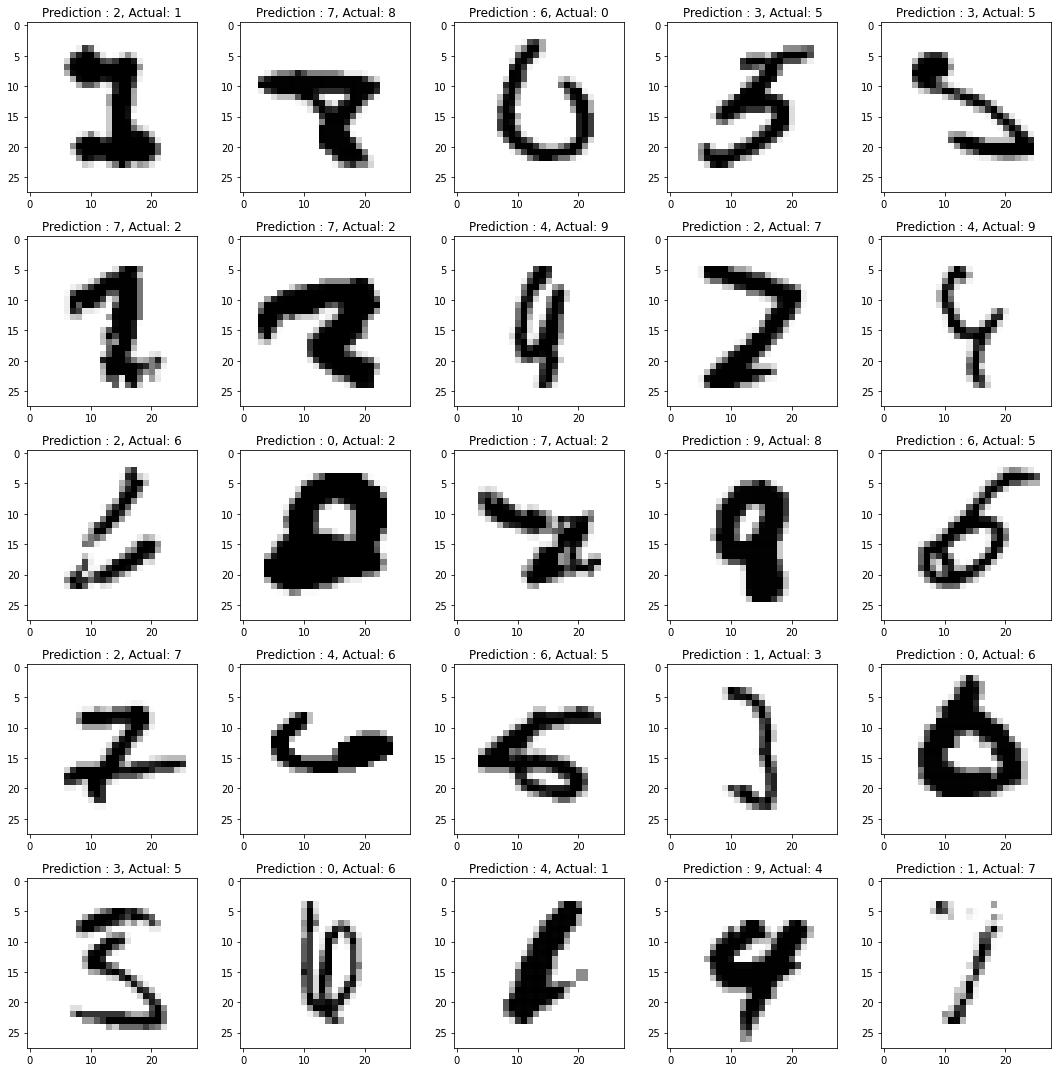

In [17]:
getMisclassifiedImages('GBN','saved_models/GBN.pt')
